In [2]:
import os
import scipy.signal as sp
%matplotlib inline
# import nbimporter
import sys  

sys.path.append('../Libraries') # adjust as needed

# load the local library
import sdc_config3 as sdc
import gaussplat as gp

# array compute and plotting
import torch
import numpy as np
import matplotlib.pyplot as plt
import imageio

# for gaussian functions and plotting
from mpl_toolkits.mplot3d import Axes3D
from torch.distributions.multivariate_normal import MultivariateNormal


/Users/xiaowenyuan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Load Calibration Data

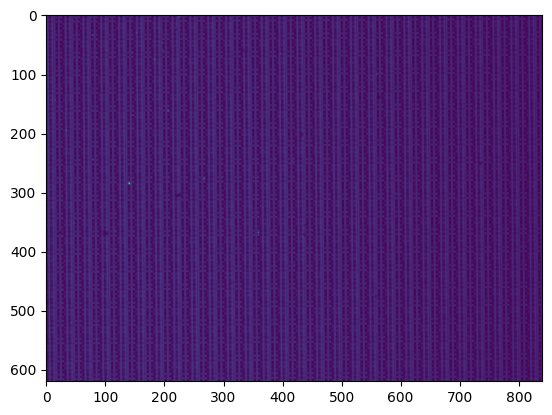

Shape of the tensor: torch.Size([620, 840, 45])


In [3]:
# Load filter calibration data
data_folder = '../Calibration_Data'
file_name = 'filterCal_every2nm_darksub_2021-02-03.mat'

# Import the filter stack from the specified file
wavelengths, ci, filter_stack = sdc.importFilterStack(data_folder, file_name)

# Adjust CI values for zero-based indexing
# Define the cropped part of the image
ci_adjusted = [ci[0] - 1, ci[1] - 1, ci[2], ci[3]]

# Define wavelength sampling parameters
wavelength_min = 450
wavelength_max = 800
wavelength_step = 8

# Create a new array of wavelengths
wavelength_new = np.arange(wavelength_min, wavelength_max + wavelength_step, wavelength_step)

# Sum the filter array over the specified wavelength range
summed_filtered_array = sdc.sumFilterArray(filter_stack, wavelengths, wavelength_min, wavelength_max, wavelength_step)

# Normalize the filter array to the maximum value
filter_array_normalized = summed_filtered_array / np.amax(summed_filtered_array)

# Convert the normalized filter array to a PyTorch tensor
filter_array_normalized_tensor = torch.tensor(filter_array_normalized)

# Extract dimensions of the tensor
dim0, dim1, dim2 = filter_array_normalized_tensor.shape

# Plot the sum of the filter array across the last dimension
plt.figure()
plt.imshow(torch.sum(filter_array_normalized_tensor, axis=2))
# plt.colorbar()  # Uncomment to display the color bar
plt.show()

# Print the shape of the tensor
print("Shape of the tensor:", filter_array_normalized_tensor.shape)

# Extract dimensions for further processing
# NL is the number of wavelengths
NY, NX, NL = filter_array_normalized_tensor.shape

torch.Size([620, 840])


/var/folders/28/3cj3m_9j28z7nvy5l5vw45rm0000gn/T/ipykernel_17027/2937720870.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  psf = torch.from_numpy(imageio.imread(os.path.join(datafolder, fname)))


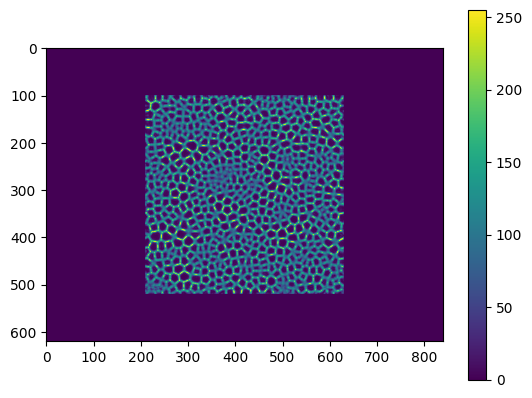

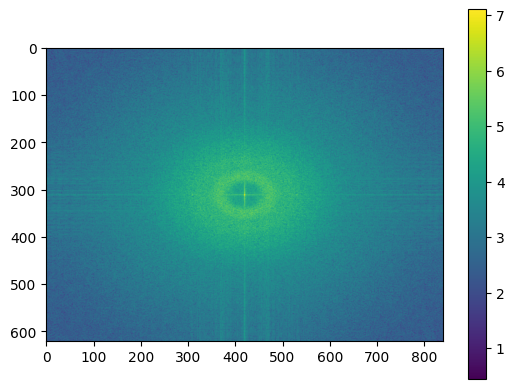

In [15]:
# load psf
datafolder = '../Calibration_Data'
# ACTION: choose psf file here
fname = 'psf_090_1.png'
# change the above two lines
psf = torch.from_numpy(imageio.imread(os.path.join(datafolder, fname)))
padded_psf = sdc.pad2d(psf)  # pad the psf
padded_psf = padded_psf[110:730,:] # make the same size as calibration data.
print(padded_psf.shape)
plt.figure()
plt.imshow(padded_psf)
plt.colorbar()
plt.show()

fft_psf = torch.fft.fftshift(torch.fft.fft2(padded_psf,dim=(0,1)))
plt.imshow(torch.log10(torch.abs(fft_psf)))
plt.colorbar()
plt.show()

# Create measurement

torch.Size([1240, 1680])


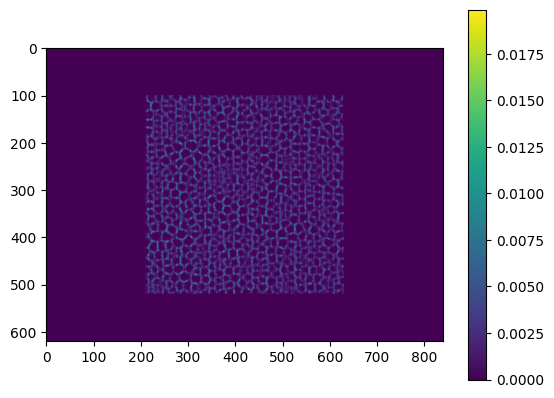

In [6]:
# initalize datacube
obj = torch.zeros_like(filter_array_normalized_tensor)
loc = [0,0] # y,x offset from center

obj[int(NY/2+loc[0]),int(NX/2+loc[1]),:] = 1.0
padded_psf = sdc.pad2d(psf) 
padded_psf = sdc.pad2d(padded_psf)
resized_padded_psf = padded_psf[220:1460,:] # make the same size as filter array
print(resized_padded_psf.shape)
resized_padded_psf_3d = sdc.make3d(resized_padded_psf,dim2) # permute along dim 2
fft_resized_padded_psf = sdc.fft3d(resized_padded_psf_3d) # take fft along dim 0 and 1
measurement = sdc.forwardmodel3d(sdc.pad3d(obj), fft_resized_padded_psf, filter_array_normalized_tensor)
measurement = measurement/torch.norm(measurement) # normalize
plt.figure()
plt.imshow(measurement)
plt.colorbar()
plt.show() 

## Now combine with gauss object

gaussObject(mu_x = 1.0, mu_y = 1.0, mu_l = 1.0), cov = tensor([[10000.,     0.],
        [    0., 10000.]], requires_grad=True)


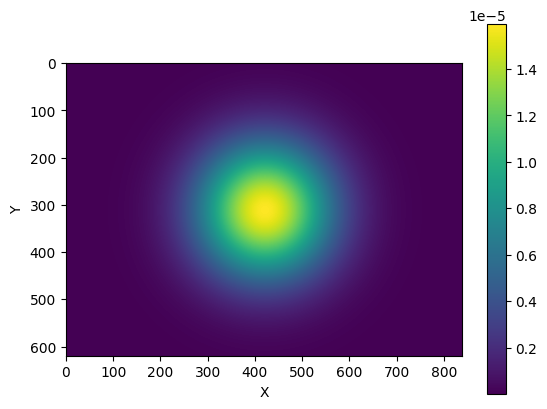

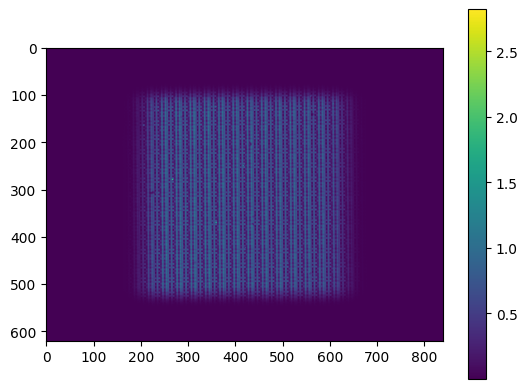

In [13]:
[x,y,coordinates] = gp.createMeshGrid(NX,NY)  
wavelengths = torch.arange(0,NL).float()
# g1 = gp.GaussObject(1.0,1.0,float(NL/2),100.0,100.0,float(NL*3),1.0) # make sure all are floating
gauss_object = gp.GaussObject(muy=1.0, mux=1.0, mul=float(NL/2), sigy=1.0, sigx=1.0, sigl=5.0, amp=1.0)

print(gauss_object)
gauss_object.plot(coordinates,NY,NX)

# forward model for each gauss object
gauss_object_measurement = gp.forwardSingleGauss(gauss_object, coordinates, NX, NY, wavelengths, fft_psf,x,y,filter_array_normalized_tensor)
plt.figure()
plt.imshow(gauss_object_measurement.detach().numpy())
plt.colorbar()
plt.show() 

In [ ]:
# try learning for a single gaussian object parameters 
 


# learning

In [35]:
# Define a Gaussian object with randomly initialized values
random_gaussian_object = gp.GaussObject(
    muy=torch.rand(1)[0].item(),   # Convert to Python float
    mux=torch.rand(1)[0].item(),   # Convert to Python float
    mul=float(NL/2),               # This can remain as float
    sigy=1.0,  # Randomly initialized float
    sigx=1.0,  # Randomly initialized float
    sigl=5.0,  # Randomly initialized float
    amp=1.0    # Randomly initialized float
)

gauss_object = gp.GaussObject(muy=1.0, mux=1.0, mul=float(NL/2), sigy=1.0, sigx=1.0, sigl=5.0, amp=1.0)

print("random_gaussian_object:", random_gaussian_object)
print("gauss_object:", gauss_object)

# Define learning rates for each parameter
learning_rates = [1e-2, 1e-2, 1e-2, 1e1, 1e-2, 1e-2]

# Set number of iterations and initialize the loss tracker
iterations = 100
loss_GD = []

# Optimization loop
for i in range(iterations):
    # Compute forward model using the current Gaussian parameters
    computed_measurement = gp.forwardSingleGauss(
        random_gaussian_object, coordinates, NX, NY, wavelengths, fft_psf, x, y, filter_array_normalized_tensor
    )
    
    # Normalize the computed measurement
    computed_measurement = computed_measurement / torch.norm(computed_measurement)
    
    # Compute PDF values based on the Gaussian parameters
    computed_values = random_gaussian_object.computeValues(coordinates, NY, NX)
    
    computed_values_np = computed_values.detach().cpu().numpy()
    computed_measurement_np = computed_measurement.detach().cpu().numpy()
    print(computed_values_np)
    
    # Plot the results every 10 iterations (optional)
    if i % 10 == 0:
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(computed_values.detach().cpu().numpy(), cmap='jet')
        plt.title("PDF Values")

        plt.subplot(1, 3, 2)
        plt.imshow(computed_measurement.detach().cpu().numpy(), cmap='jet')
        plt.title("Computed Measurement")

        plt.subplot(1, 3, 3)
        plt.imshow((computed_measurement - measurement).detach().cpu().numpy(), cmap='jet')
        plt.title("Difference (Computed - True)")
        
        plt.show()
    
    # Compute the loss (difference between computed measurement and true measurement)
    loss = torch.norm(computed_measurement - measurement)
    loss_GD.append(loss.item())
    
    # Print the current loss for monitoring
    print(f"Iteration {i+1}/{iterations}, Loss: {loss.item():.4f}")
    
    # Perform a gradient step to update Gaussian parameters
    random_gaussian_object.gradStep(learning_rates)
    
    # Zero the gradients after the update
    random_gaussian_object.zeroGrad()

# Plot the loss over iterations
plt.figure()
plt.plot(loss_GD)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss during Gradient Descent')
plt.show()


random_gaussian_object: gaussObject(mu_x = 0.8126363158226013, mu_y = 0.9865292906761169, mu_l = 22.5), cov = tensor([[1., 0.],
        [0., 1.]], requires_grad=True)
gauss_object: gaussObject(mu_x = 1.0, mu_y = 1.0, mu_l = 22.5), cov = tensor([[1., 0.],
        [0., 1.]], requires_grad=True)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Iteration 1/100, Loss: 1.0464


AttributeError: 'NoneType' object has no attribute 'data'

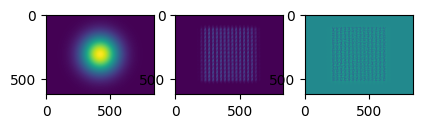

tensor([[-5.1678e-08, -1.9565e-09],
        [-1.0659e-09, -1.1564e-07]])
tensor(-0.0047)


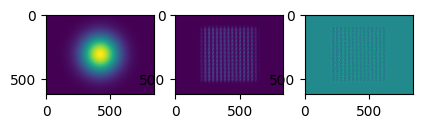

tensor([[-5.1607e-08, -1.9549e-09],
        [-1.0650e-09, -1.1564e-07]])
tensor(-0.0040)


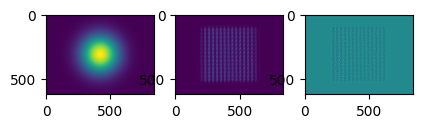

tensor([[-5.1546e-08, -1.9534e-09],
        [-1.0642e-09, -1.1563e-07]])
tensor(-0.0034)


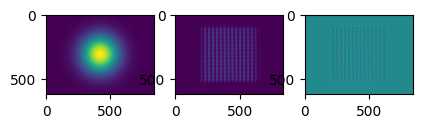

tensor([[-5.1492e-08, -1.9520e-09],
        [-1.0634e-09, -1.1563e-07]])
tensor(-0.0030)


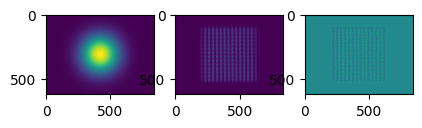

tensor([[-5.1447e-08, -1.9507e-09],
        [-1.0627e-09, -1.1563e-07]])
tensor(-0.0025)


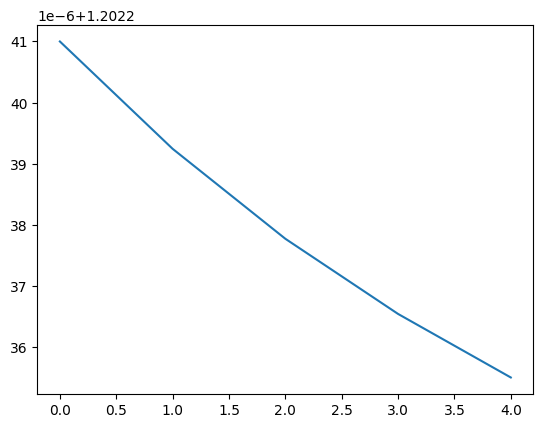

In [19]:
lr = [1e-2, 1e-2, 1e-2, 1e1, 1e-2, 1e-2] # mux, muy, mul, cov, sigl, amp
# how to set the learning rate? 
iterations = 5
loss_GD = []

# normalize the measurement
for k2 in range(iterations):
    # compute forward model
    padded_psf_zeros = torch.zeros_like(padded_psf)
    individual_measurements = padded_psf_zeros + gp.forwardSingleGauss(gauss_object, coordinates, NX, NY, wavelengths, fft_psf, x,y, filter_array_normalized_tensor)  # compute individual measurements
    computed_values = gauss_object.computeValues(coordinates, NY, NX)
    individual_measurements = individual_measurements/torch.norm(individual_measurements)
    
    # plot the beads
    plt.figure()
    plt.subplot(1,4,1)
    plt.imshow(computed_values.detach().numpy()) ## pdf values
    plt.subplot(1,4,2)
    plt.imshow(individual_measurements.detach().numpy()) ## individual measurements
    plt.subplot(1,4,3)
    plt.imshow((individual_measurements-measurement).detach().numpy()) ## difference between reconstructed measurements and true measurement
    plt.show()
    
    # compute loss
    loss = torch.norm(individual_measurements - measurement)
    loss_GD.append(loss.item())
    loss.backward()

    # print gradients
    print(gauss_object.covariancematrix.grad.data)
    print(gauss_object.mux.grad.data)
    # update gaussian parameters
    gauss_object.gradStep(lr)
    gauss_object.zeroGrad()

plt.figure()
plt.plot(loss_GD)       
    

In [ ]:
## visualize computational graph

import torch
from torchviz import make_dot

# Define a simple neural network model
class SimpleModel(torch.nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc1 = torch.nn.Linear(2, 2)  # First fully connected layer with 2 inputs and 2 outputs
        self.fc2 = torch.nn.Linear(2, 1)  # Second fully connected layer with 2 inputs and 1 output

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Apply ReLU activation to the output of the first layer
        x = self.fc2(x)  # Pass the output through the second layer
        return x

# Initialize the model
model = SimpleModel()

# Create a random input tensor
input_tensor = torch.randn(1, 2)  # Batch size 1, 2 features

# Forward pass to generate the output tensor
output_tensor = model(input_tensor)

# Generate the computation graph visualization
dot = make_dot(output_tensor, params=dict(model.named_parameters()))
dot.view()


ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [ ]:
import graphviz

# Check if the 'dot' executable is found
graphviz.backend.DOT_PATH

AttributeError: module 'graphviz.backend' has no attribute 'DOT_PATH'